<a href="https://colab.research.google.com/github/StetskoSergey/algotrade/blob/main/%22timeseries_forecaster%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autokeras

In [ ]:
import pandas as pd
import numpy as np
import autokeras as ak
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Input
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
import seaborn as sns                                                           # Библиотека готовых шаблонов для статистической визуализации
%matplotlib inline
import numpy as np                                                              # Работа с массивами данных
import pandas as pd                                                             # Работа с табличными данными
from tensorflow.keras import utils                                              # Функции-утилиты для работы с категориальными данными
from tensorflow.keras.models import Sequential, Model                           # Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D,BatchNormalization, Embedding, Flatten, Activation, Input,Conv1D,MaxPooling1D,LSTM # Основные слои
from tensorflow.keras.optimizers import Adam                                    # Оптимизаторы
from sklearn.preprocessing import StandardScaler,MinMaxScaler                   # Масштабирование данных
import re                                                                       # Регулярные выражения
import matplotlib.pyplot as plt                                                  # Отрисовка графиков
from sklearn.metrics import mean_squared_error, mean_absolute_error             # Метрики для расчета ошибок
import yfinance as yf
sns.set_style('dark')
plt.style.use("bmh")
from datetime import datetime                                                   # Модуль для работы с датами и временем
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator         # Генератор выборки временных рядов

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Mihail_treid/kotirovki.csv')
df=df.set_index('Opentime')
df=df.drop([
    'Quotee',
    'TakerBuyBaseAssetVolume',
    'TakerBuyQuoteAssetVolume',
    'Number',
    'Closetime',
    'Unnamed: 0',
    'Ignore'
    ],axis=1)
display(df)
dataset = df

,Open,High,Low,Close,Volume
Opentime,,,,,
2022-11-21 20:00:00,16031.0,16160.0,16020.0,16098.4,5144.183
2022-11-21 21:00:00,16098.4,16200.0,15938.9,15975.6,5530.476
2022-11-21 22:00:00,15975.6,16270.0,15650.0,15726.4,10280.221
2022-11-21 23:00:00,15726.4,15890.0,15656.0,15802.4,6936.928
2022-11-22 00:00:00,15786.5,16279.9,15601.0,15681.0,6663.291
...,...,...,...,...,...
2023-05-07 07:00:00,28785.5,29000.0,28614.5,28785.5,4384.760
2023-05-07 08:00:00,28650.0,29075.3,28614.5,28700.0,4002.324
2023-05-07 09:00:00,28785.5,29021.0,28658.0,28913.7,4343.797


## Подготовка данных и обучение TimeseriesForecaster

In [ ]:
val_split = int(len(dataset) * 0.7)
data_train = dataset[:val_split]
validation_data = dataset[val_split:]
print(val_split)

2800


In [ ]:

data_x = data_train[
    [
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
    ]
].astype("float64")

data_x_val = validation_data[
    [
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
    ]
].astype("float64")

# Data with train data and the unseen data from subsequent time steps.
data_x_test = dataset[
    [
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
    ]
].astype("float64")

data_y = data_train["Close"].astype("float64")

data_y_val = validation_data["Close"].astype("float64")

print(data_x.shape)
print(data_y.shape)
print(data_x_val.shape)
print(data_x_test.shape)

(2800, 5)
(2800,)
(1200, 5)
(4000, 5)


In [ ]:
predict_from = 1
predict_until = 5
lookback = 32 # lookback должен быть кратен batch_size
clf = ak.TimeseriesForecaster(
    lookback=lookback,  # количество предыдущих временных шагов, которые будут использоваться для прогнозирования следующего временного шага
    predict_from= predict_from,  # это индексы временных шагов, на которых модель будет производить прогнозы
    predict_until= predict_until, # модель будет прогнозировать значения для временных шагов с индексами от predict_from до predict_until.
    max_trials=10,  # количество различных моделей, которые будут протестированы
    objective="val_loss",  # целевая метрика, на основе которой будет производиться оптимизация модели
    overwrite=True,  # если True, то при повторном запуске обучения модели, будут перезаписаны результаты прошлого запуска
    # directory='/path/to/directory',
    seed=42,  # начальное значение генератора случайных чисел для повторяемости эксперимента
    metrics=['mse']  # список дополнительных метрик, которые будут отслеживаться в процессе обучения
)
# Обучение TimeSeriesForecaster с помощью данных
clf.fit(
    x=data_x,
    y=data_y,
    validation_data=(data_x_val, data_y_val),
    batch_size=32,
    epochs=100,
)
# Прогнозирование с помощью наилучшей модели (включает исходные данные обучения).
predictions = clf.predict(data_x_test)
print(predictions.shape)
# Оцените лучшую модель с помощью тестовых данных.
print(clf.evaluate(data_x_val, data_y_val))

Trial 10 Complete [00h 03m 35s]
val_loss: 818807040.0

Best val_loss So Far: 388431712.0
Total elapsed time: 00h 33m 48s
Epoch 1/100
87/87 [==============================] - 9s 38ms/step - loss: 416192800.0000 - mse: 416192800.0000 - val_loss: 813504000.0000 - val_mse: 813504000.0000
Epoch 2/100
87/87 [==============================] - 2s 18ms/step - loss: 412492960.0000 - mse: 412492960.0000 - val_loss: 808446912.0000 - val_mse: 808446912.0000
Epoch 3/100
87/87 [==============================] - 1s 15ms/step - loss: 408971584.0000 - mse: 408971584.0000 - val_loss: 803494976.0000 - val_mse: 803494976.0000
Epoch 4/100
87/87 [==============================] - 1s 16ms/step - loss: 405508000.0000 - mse: 405508000.0000 - val_loss: 798599680.0000 - val_mse: 798599680.0000
Epoch 5/100
87/87 [==============================] - 1s 15ms/step - loss: 401679200.0000 - mse: 401679200.0000 - val_loss: 792491904.0000 - val_mse: 792491904.0000
Epoch 6/100
87/87 [==============================] - 1s 16m

125/125 [==============================] - 1s 10ms/step
(5, 1)
37/37 [==============================] - 2s 8ms/step - loss: 388096992.0000 - mse: 388096992.0000
[388096992.0, 388096992.0]


In [ ]:
# Применение модели для прогнозирования значений на новых данных
y_pred = clf.predict(dataset)
print(y_pred)

125/125 [==============================] - 1s 9ms/step
[[8924.798]
 [8924.798]
 [8924.798]
 [8924.798]
 [8924.798]]


In [ ]:
model1 = clf.export_model()
# Получите архитектуру модели в виде JSON строки
model_json = model1.to_json()

print("Model architecture:")
print(model_json)

Model architecture:
{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 32, 5], "dtype": "float64", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Bidirectional", "config": {"name": "bidirectional", "trainable": true, "dtype": "float32", "layer": {"class_name": "LSTM", "config": {"name": "lstm", "trainable": true, "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "time_major": false, "units": 5, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}, "shared_object_id": 1}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}, "shared_object_id": 2}, "bias_initializer": {"class_name": "Zeros", "config": {}, "s

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 5)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 32, 10)           440       
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 10)               640       
 nal)                                                            
                                                                 
 regression_head_1 (Dense)   (None, 1)                 11        
                                                                 
Total params: 1,091
Trainable params: 1,091
Non-trainable params: 0
_________________________________________________________________


## Не зашло обучение через TimeseriesForecaster но взял предложенную AK модель

In [ ]:
# Задание текстовых меток каналов данных (столбцов)
CHANNEL_NAMES = [
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
    ]

# Получение словаря с именами и индексами каналов данных
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}
print(CHANNEL_INDEX,df.shape)

{'Open': 0, 'High': 1, 'Low': 2, 'Close': 3, 'Volume': 4} (4000, 5)


In [ ]:
# Задание гиперпараметров

CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['Close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 32                              # Длина прошедших данных для анализа
BATCH_SIZE = 2                            # Объем батча для генератора
TEST_LEN = 800                            # Объем тестовой выборки
TRAIN_LEN = df.shape[0] - TEST_LEN      # Объем обучающей выборки
col = 710

In [ ]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

[0, 1, 2, 3, 4] [3]


In [ ]:
data = df.to_numpy()

In [ ]:
# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными
# варьируемый параметр, страховка от пересечения
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train,
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test,
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

Train data: (3200, 5), (3200, 1)
Test  data: (736, 5), (736, 1)
Train batch x: (2, 32, 5), y: (2, 1)


In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test,
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (704, 32, 5), y: (704, 1)


## ФунКции

In [ ]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [ ]:
# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]


In [ ]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))

    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn],
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [ ]:
# Функция рисования корреляций прогнозного ряда и исходного со смещением

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y,
              title=''): # список имен каналов данных

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [ ]:
# Функция визуализации результата работы сети

def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):

    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)

    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    show_predict(y_pred[1:], y_true[:-1], start, length,
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max,
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [ ]:
# Функция обучения модели и отрисовки прогресса и оценки результатов

def train_eval_net(model, # модель
                   train_datagen, val_datagen, # генераторы обучающей и проверочной выборок
                   epoch_list, # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test,
                   y_scaler,
                   start=0,
                   length=500,
                   back_steps_max=30,
                   title=''):

    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen,
                            epochs=epochs,
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start,
                 length=length, back_steps_max=back_steps_max, title=title)

## Модели


In [ ]:
x_test.shape[1:]

(32, 5)

In [ ]:
# Модель с одномерной сверткой
model_conv = Sequential()
model_conv.add(Conv1D(64, 5, input_shape=x_test.shape[1:], activation='relu'))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(100, activation='relu'))
model_conv.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 50+20 эпох
train_eval_net(model_conv, train_datagen, val_datagen, [(50, Adam(lr=1e-4)),
                                                        (20, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка')

In [ ]:
# Поторяем архитектуру предложенную AK
inputs = Input(x_test.shape[1:])
x = Bidirectional(LSTM(units=5, activation='tanh', return_sequences=True), input_shape=(16, 5))(inputs)
x = Bidirectional(LSTM(units=5, activation='tanh'))(x)
x = Dropout(rate=0.25)(x)
outputs = Dense(units=1, activation='linear')(x)

model = Model(inputs=inputs, outputs=outputs)

# Компилируем модель
model.compile(loss='mse', optimizer='adam')

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 5)]           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 32, 10)           440       
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 10)               640       
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,091
Trainable params: 1,091
Non-trainable p

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 5)]           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 32, 10)           440       
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 10)               640       
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,091
Trainable params: 1,091
Non-trainable p

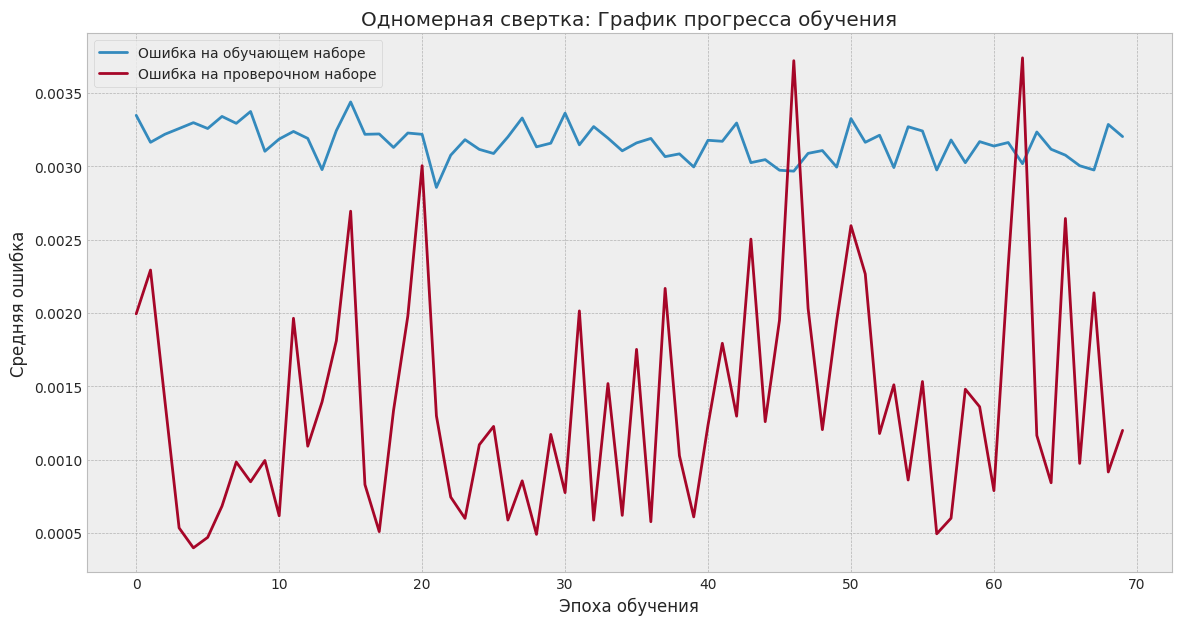

22/22 [==============================] - 1s 4ms/step


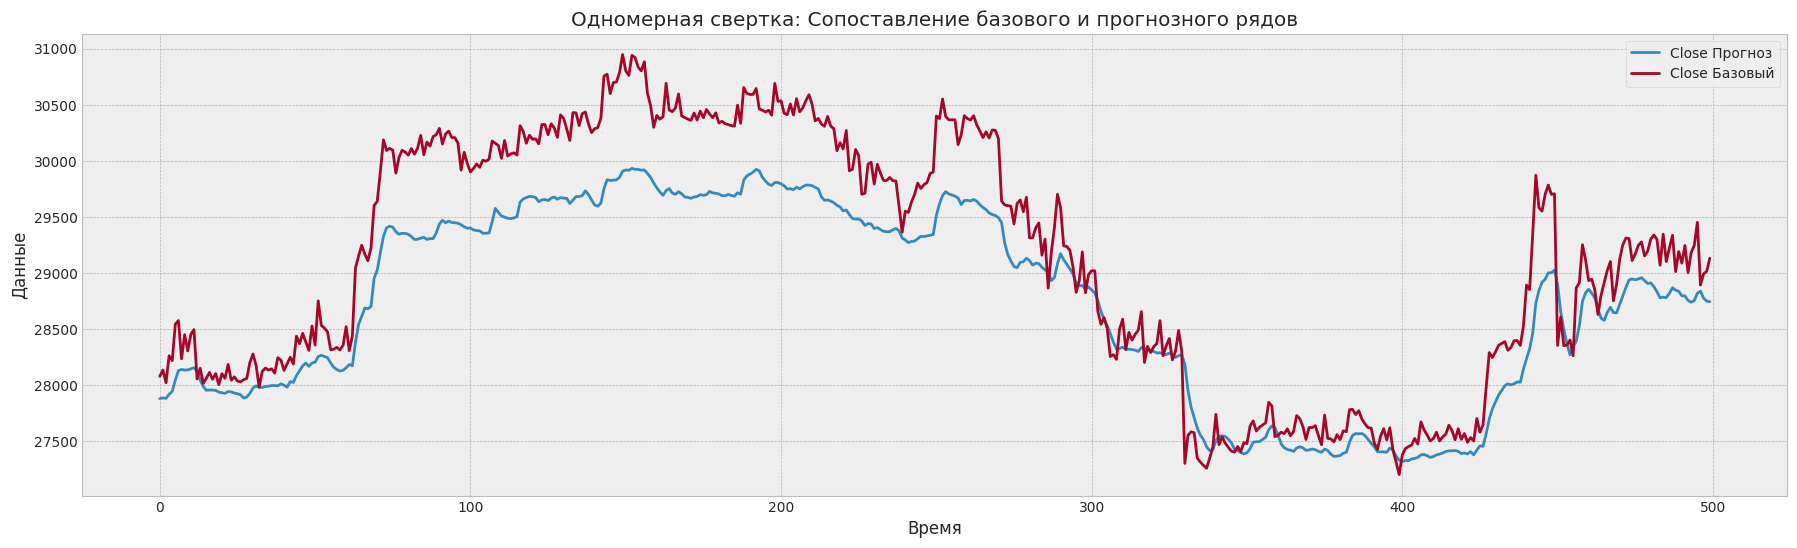

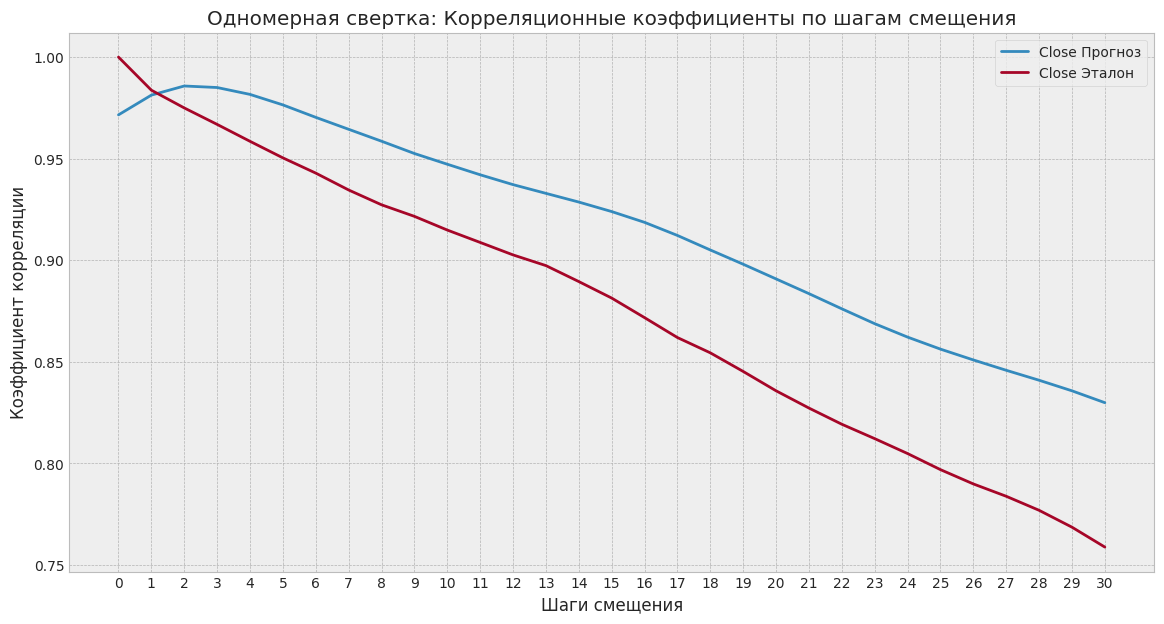

Обучение 20 эпох
Epoch 1/20
1584/1584 [==============================] - 30s 14ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 2/20
1584/1584 [==============================] - 22s 14ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 3/20
1584/1584 [==============================] - 25s 16ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 4/20
1584/1584 [==============================] - 21s 13ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 5/20
1584/1584 [==============================] - 21s 13ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 6/20
1584/1584 [==============================] - 21s 13ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 7/20
1584/1584 [==============================] - 22s 14ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 8/20
1584/1584 [==============================] - 21s 13ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 9/20
1584/1584 [==============================] - 20s 13ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 10/20
1584/1584 [========================

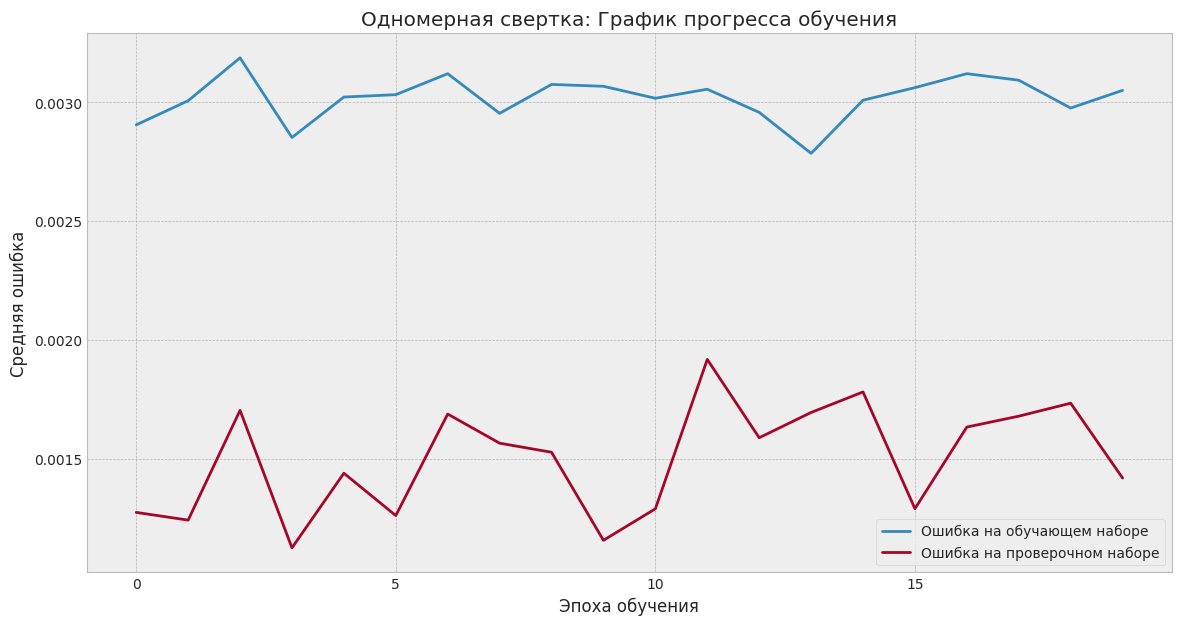

22/22 [==============================] - 2s 5ms/step


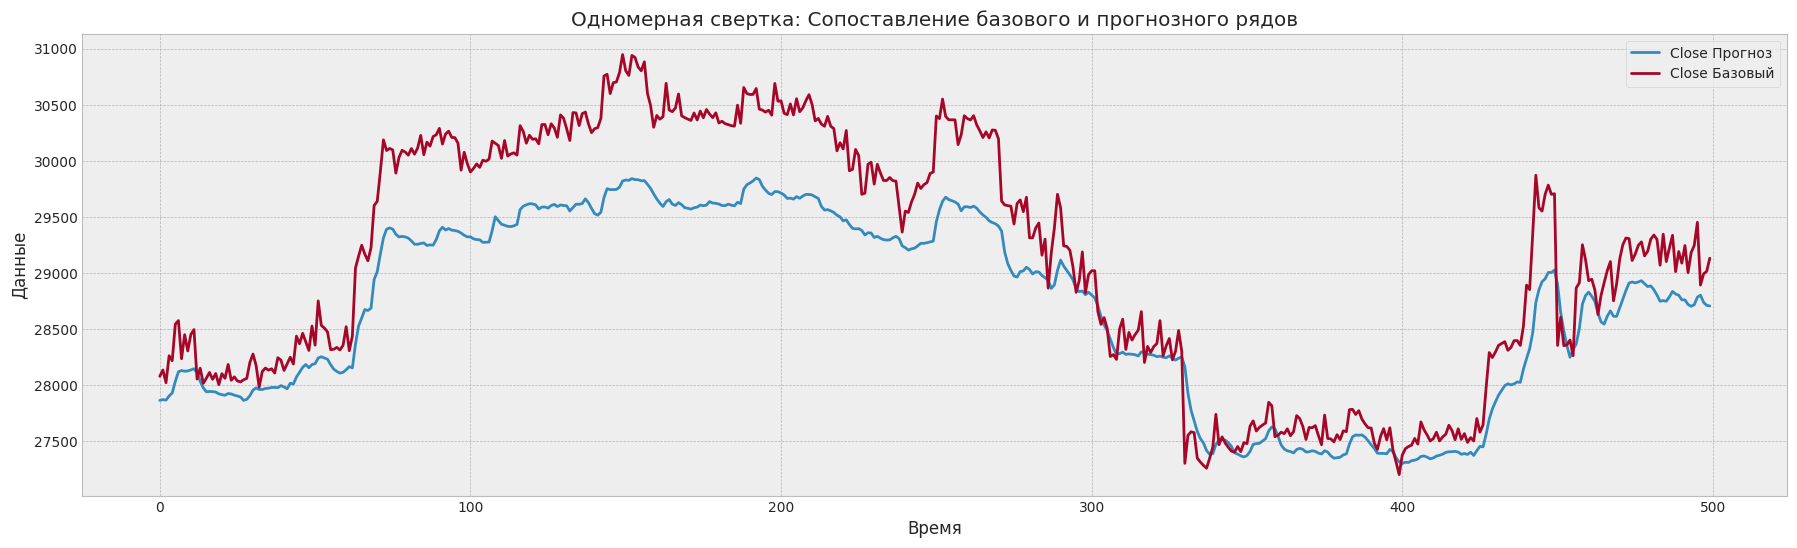

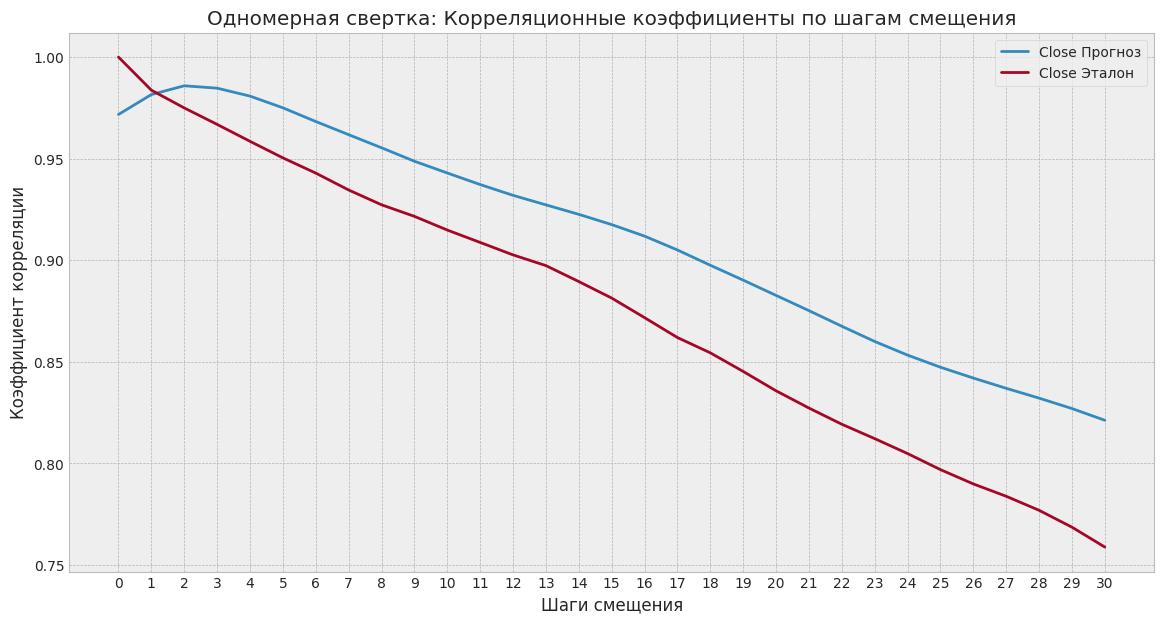

In [ ]:
train_eval_net(model, train_datagen, val_datagen, [(70, Adam(learning_rate=1e-4)),
                                                    (20, Adam(learning_rate=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка')

In [ ]:
model.save('/content/drive/MyDrive/model_Bidirectional_BCTall.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 50)            1300      
                                                                 
 flatten (Flatten)           (None, 1400)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                14010     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 15,321
Trainable params: 15,321
Non-trainable params: 0
_________________________________________________________________
Обучение 20 эпох
Epoch 1/20
1584/1584 [==============================] - 12s 4ms/step - loss: 0.0075 - val_loss: 0.0020
Epoch 2/20
1584/1584 [==============================] - 7s 4ms/s

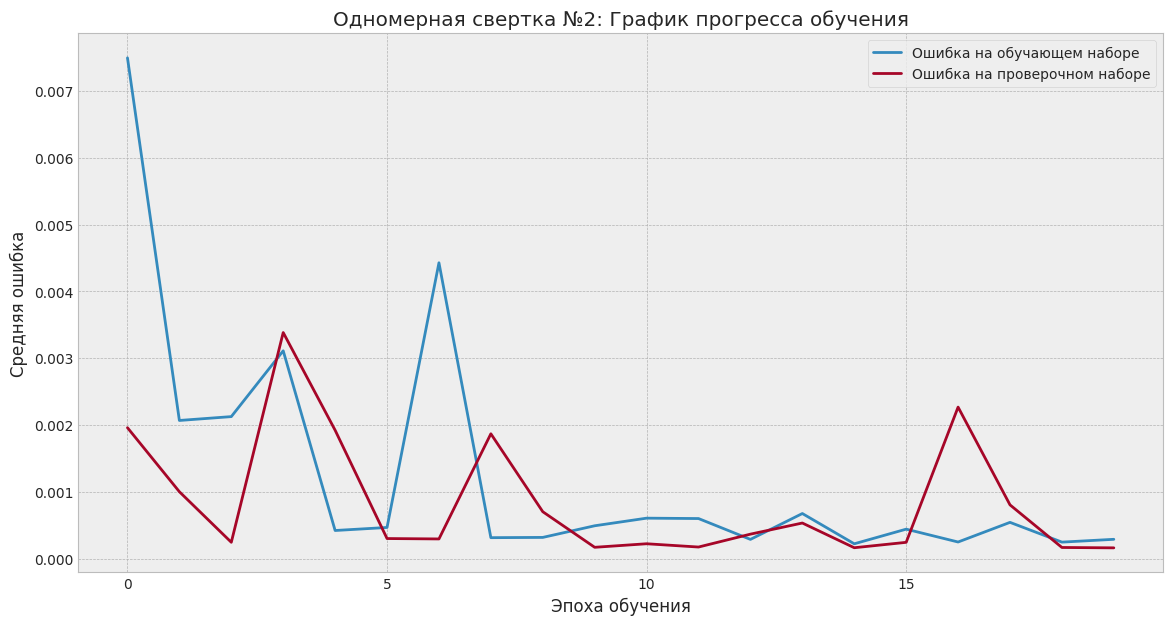

22/22 [==============================] - 0s 2ms/step


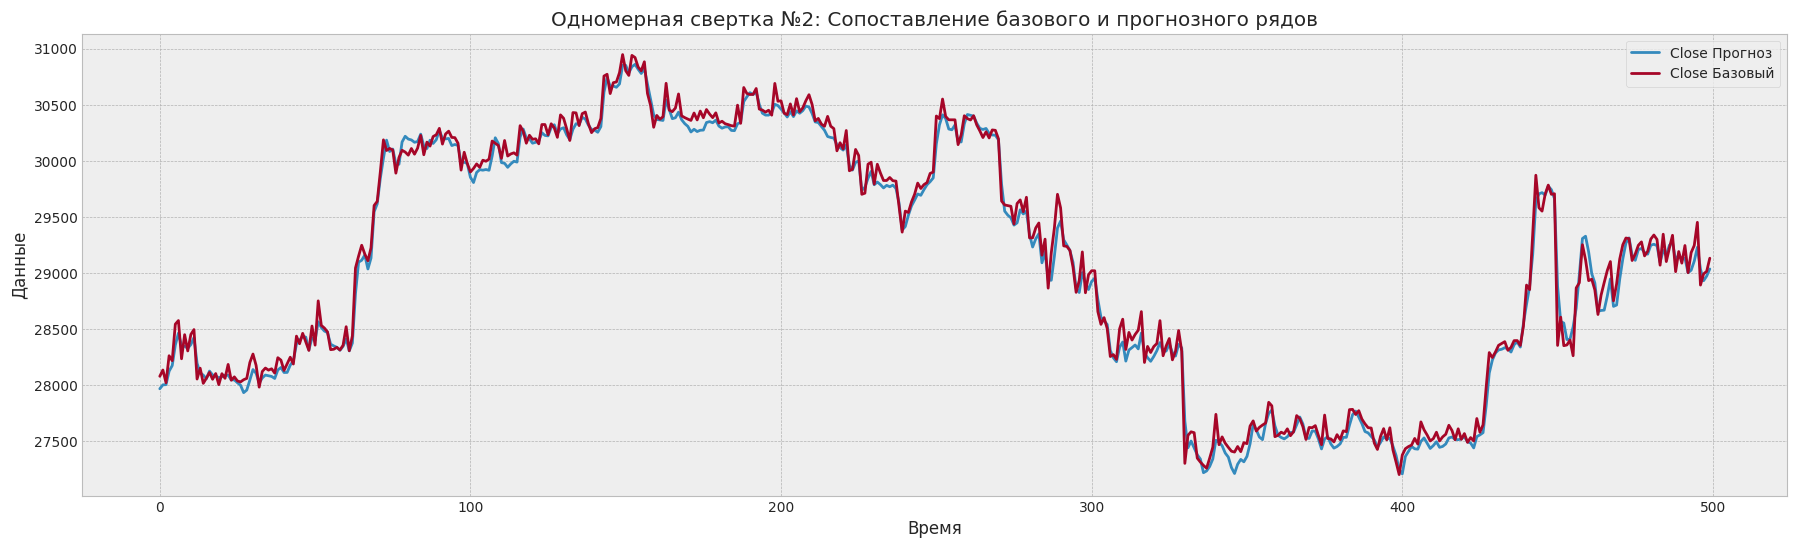

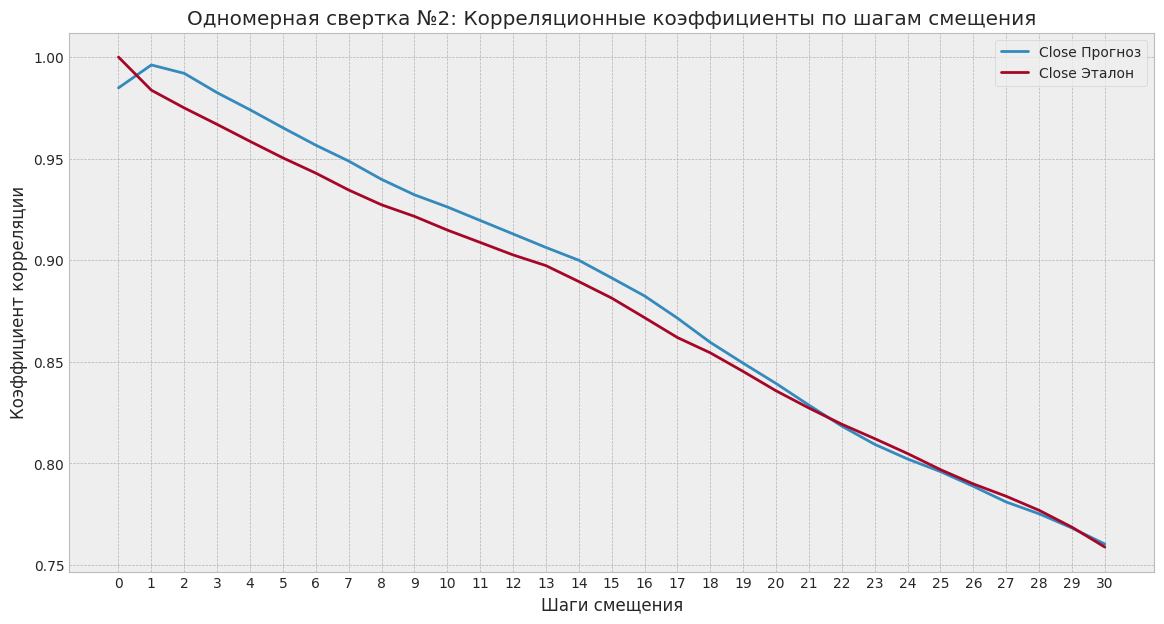

Обучение 20 эпох
Epoch 1/20
1584/1584 [==============================] - 8s 4ms/step - loss: 2.4183e-04 - val_loss: 6.4968e-04
Epoch 2/20
1584/1584 [==============================] - 6s 4ms/step - loss: 3.8584e-04 - val_loss: 1.8880e-04
Epoch 3/20
1584/1584 [==============================] - 7s 5ms/step - loss: 2.1607e-04 - val_loss: 1.9312e-04
Epoch 4/20
1584/1584 [==============================] - 6s 4ms/step - loss: 0.0014 - val_loss: 2.6072e-04
Epoch 5/20
1584/1584 [==============================] - 7s 4ms/step - loss: 1.7003e-04 - val_loss: 3.5854e-04
Epoch 6/20
1584/1584 [==============================] - 6s 4ms/step - loss: 1.9902e-04 - val_loss: 1.8973e-04
Epoch 7/20
1584/1584 [==============================] - 7s 4ms/step - loss: 2.0488e-04 - val_loss: 1.7546e-04
Epoch 8/20
1584/1584 [==============================] - 6s 4ms/step - loss: 3.3302e-04 - val_loss: 3.4371e-04
Epoch 9/20
1584/1584 [==============================] - 7s 5ms/step - loss: 2.0607e-04 - val_loss: 2.2784e-

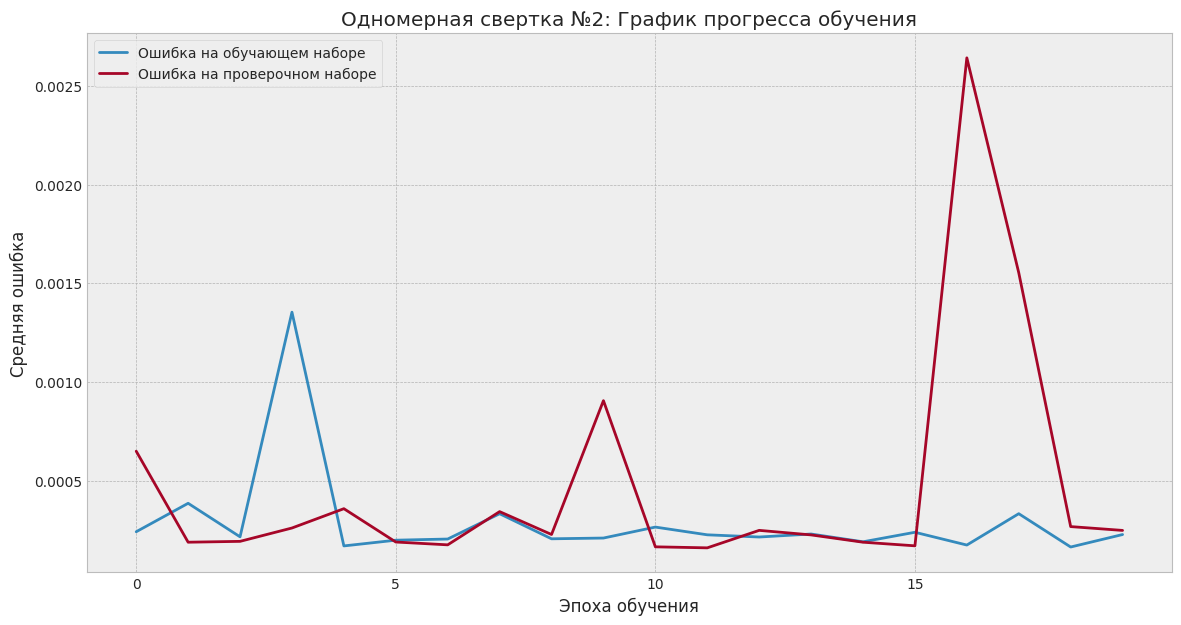

22/22 [==============================] - 0s 2ms/step


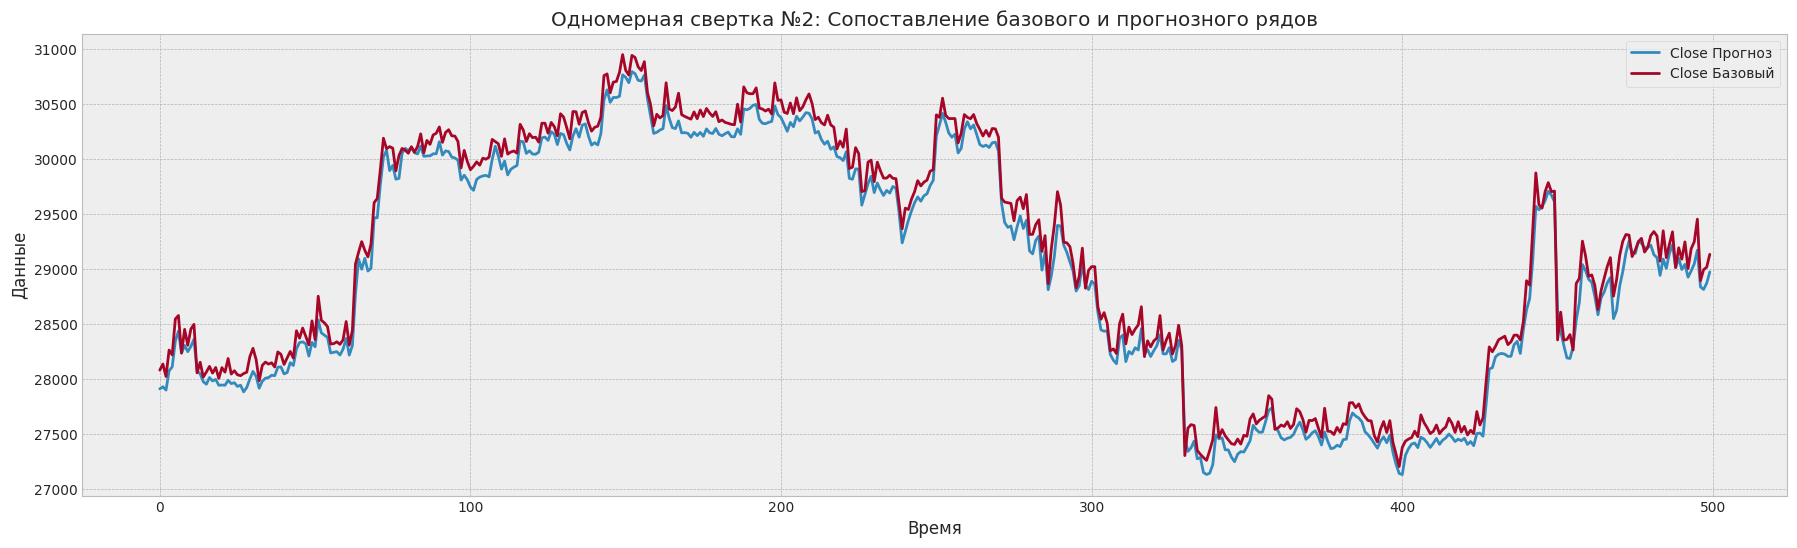

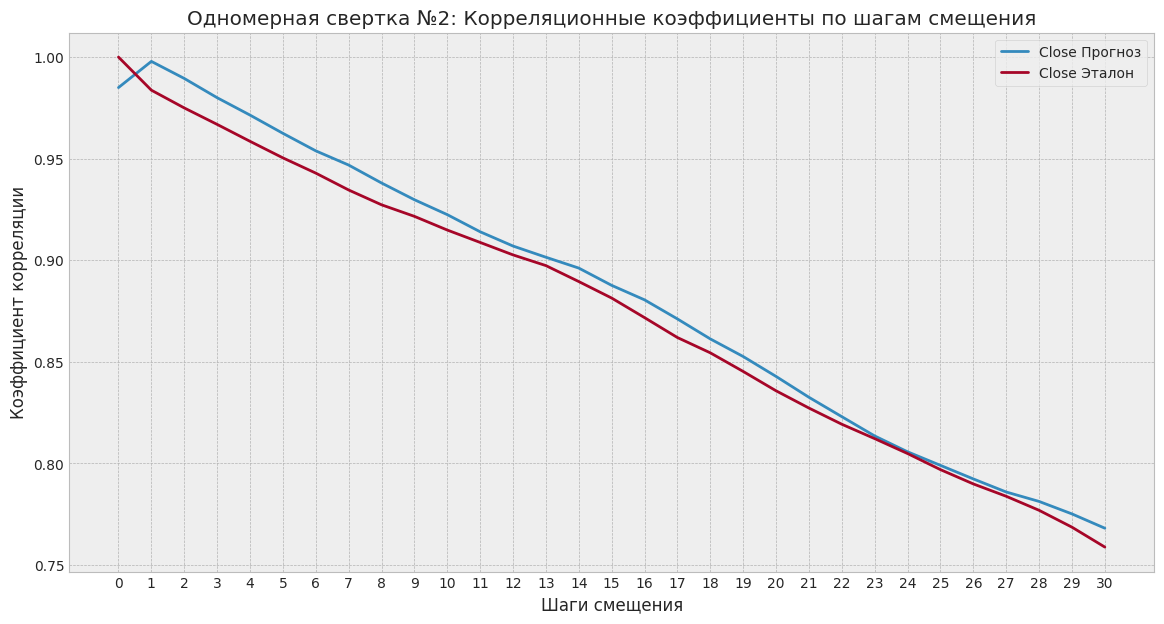

In [ ]:
# Упрощенная модель с одномерной сверткой
model_conv_2 = Sequential()
model_conv_2.add(Conv1D(50, 5, input_shape=x_test.shape[1:], activation='linear'))
model_conv_2.add(Flatten())
model_conv_2.add(Dense(10, activation='linear'))
model_conv_2.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 2x20 эпох
train_eval_net(model_conv_2, train_datagen, val_datagen, [(20, Adam(lr=1e-4)),
                                                          (20, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка №2')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32, 40)            7360      
                                                                 
 lstm_7 (LSTM)               (None, 20)                4880      
                                                                 
 dense_4 (Dense)             (None, 25)                525       
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 12,791
Trainable params: 12,791
Non-trainable params: 0
_________________________________________________________________
Обучение 20 эпох
Epoch 1/20
1584/1584 [==============================] - 18s 9ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 2/20
1584/1584 [==============================] - 13s 8m

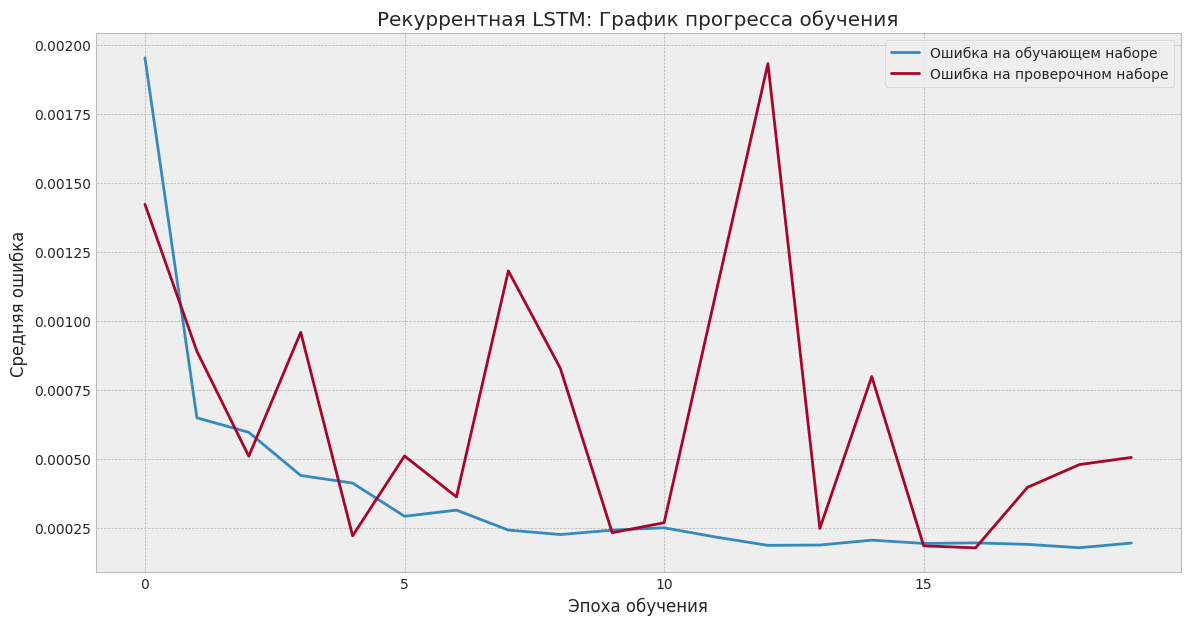

22/22 [==============================] - 2s 4ms/step


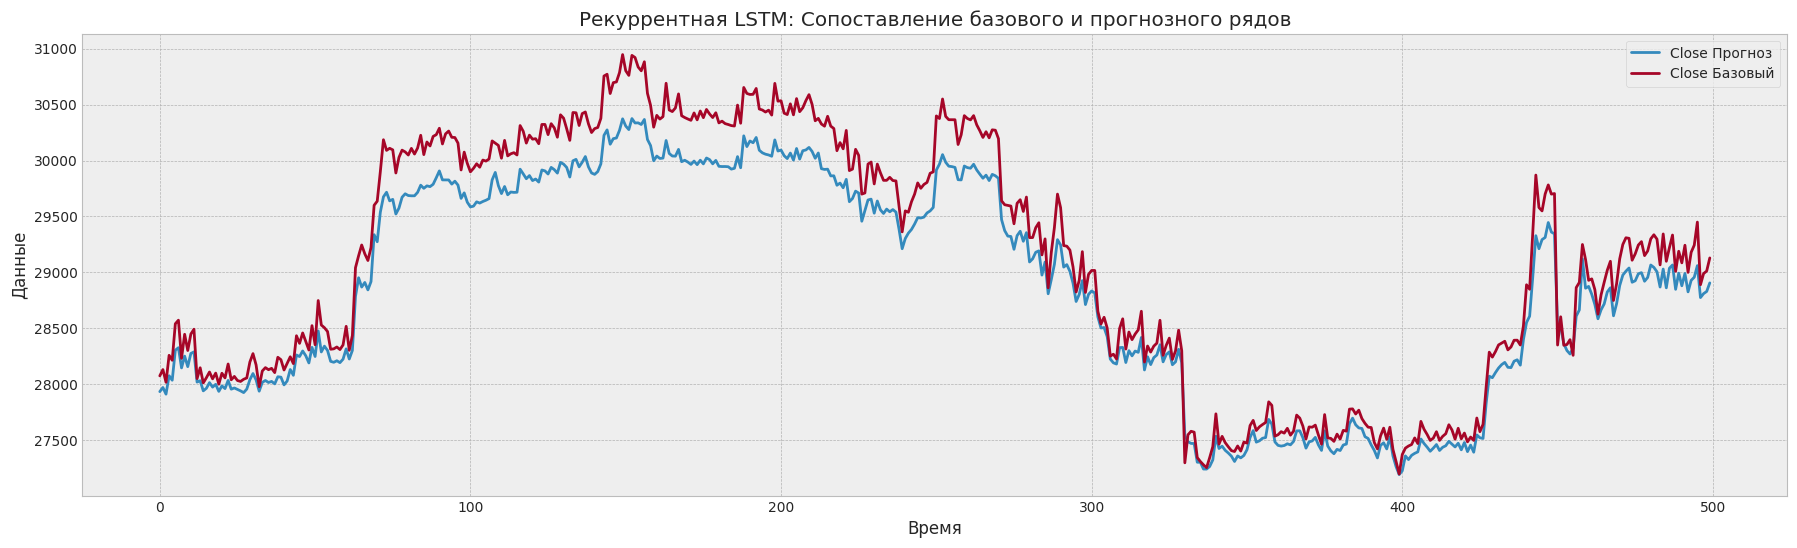

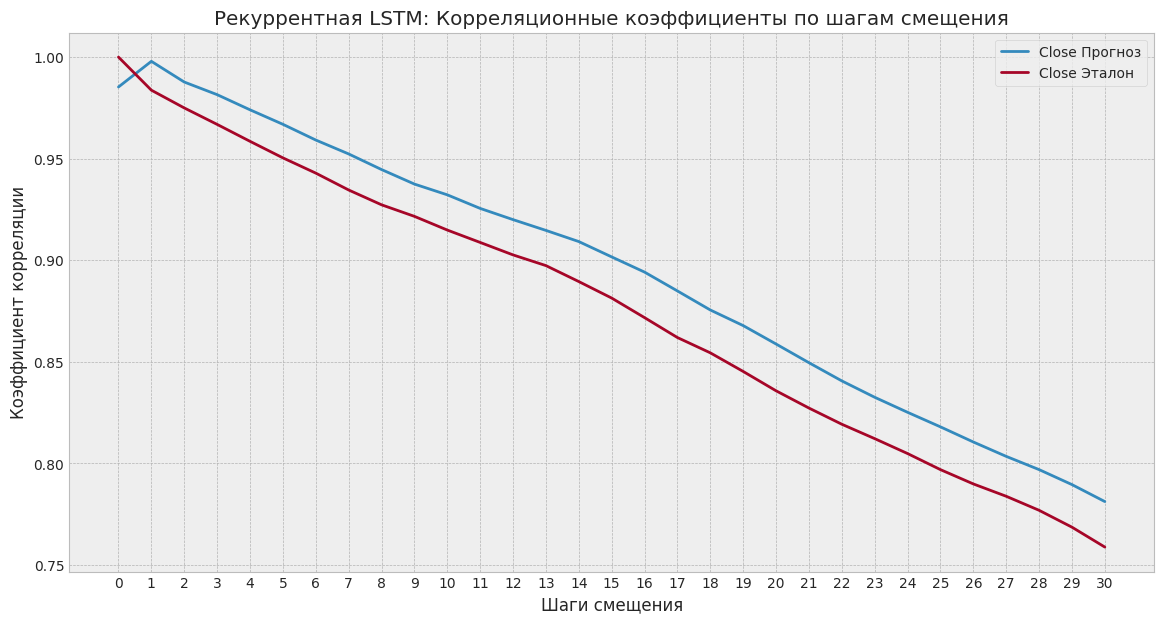

Обучение 20 эпох
Epoch 1/20
1584/1584 [==============================] - 18s 9ms/step - loss: 1.8935e-04 - val_loss: 0.0025
Epoch 2/20
1584/1584 [==============================] - 14s 9ms/step - loss: 1.7385e-04 - val_loss: 1.7470e-04
Epoch 3/20
1584/1584 [==============================] - 14s 9ms/step - loss: 1.5468e-04 - val_loss: 8.4454e-04
Epoch 4/20
1584/1584 [==============================] - 14s 9ms/step - loss: 1.4960e-04 - val_loss: 6.6878e-04
Epoch 5/20
1584/1584 [==============================] - 14s 9ms/step - loss: 1.8983e-04 - val_loss: 7.5666e-04
Epoch 6/20
1584/1584 [==============================] - 14s 9ms/step - loss: 1.9515e-04 - val_loss: 2.5743e-04
Epoch 7/20
1584/1584 [==============================] - 13s 8ms/step - loss: 1.5944e-04 - val_loss: 2.5104e-04
Epoch 8/20
1584/1584 [==============================] - 13s 8ms/step - loss: 1.6867e-04 - val_loss: 5.3092e-04
Epoch 9/20
1584/1584 [==============================] - 13s 8ms/step - loss: 1.7596e-04 - val_loss:

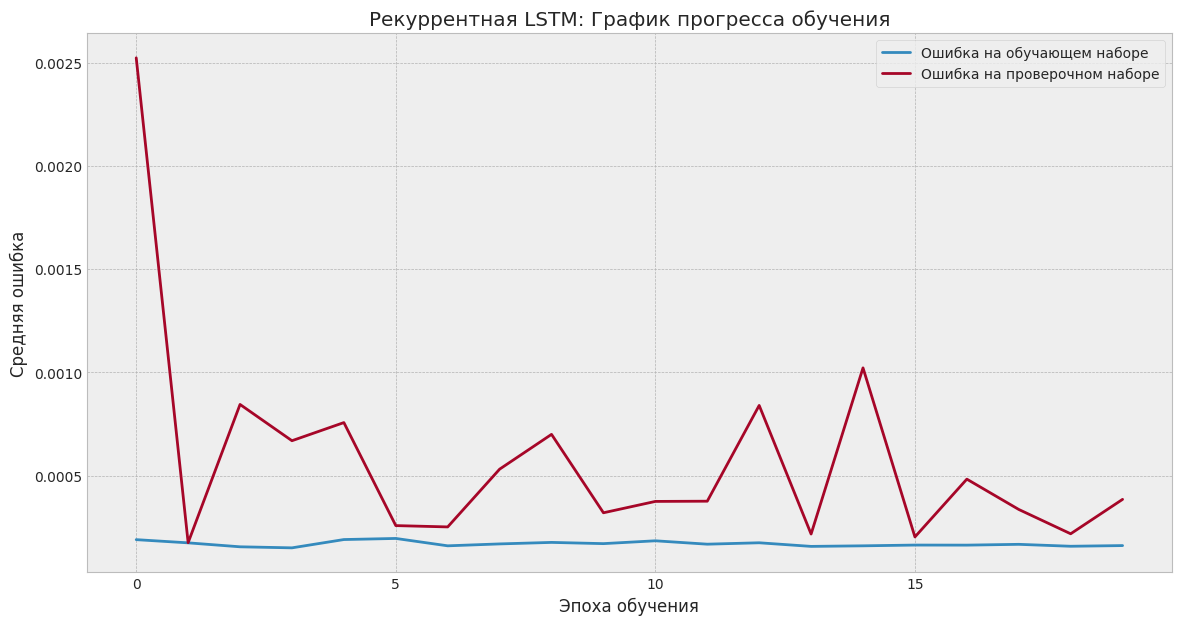

22/22 [==============================] - 1s 4ms/step


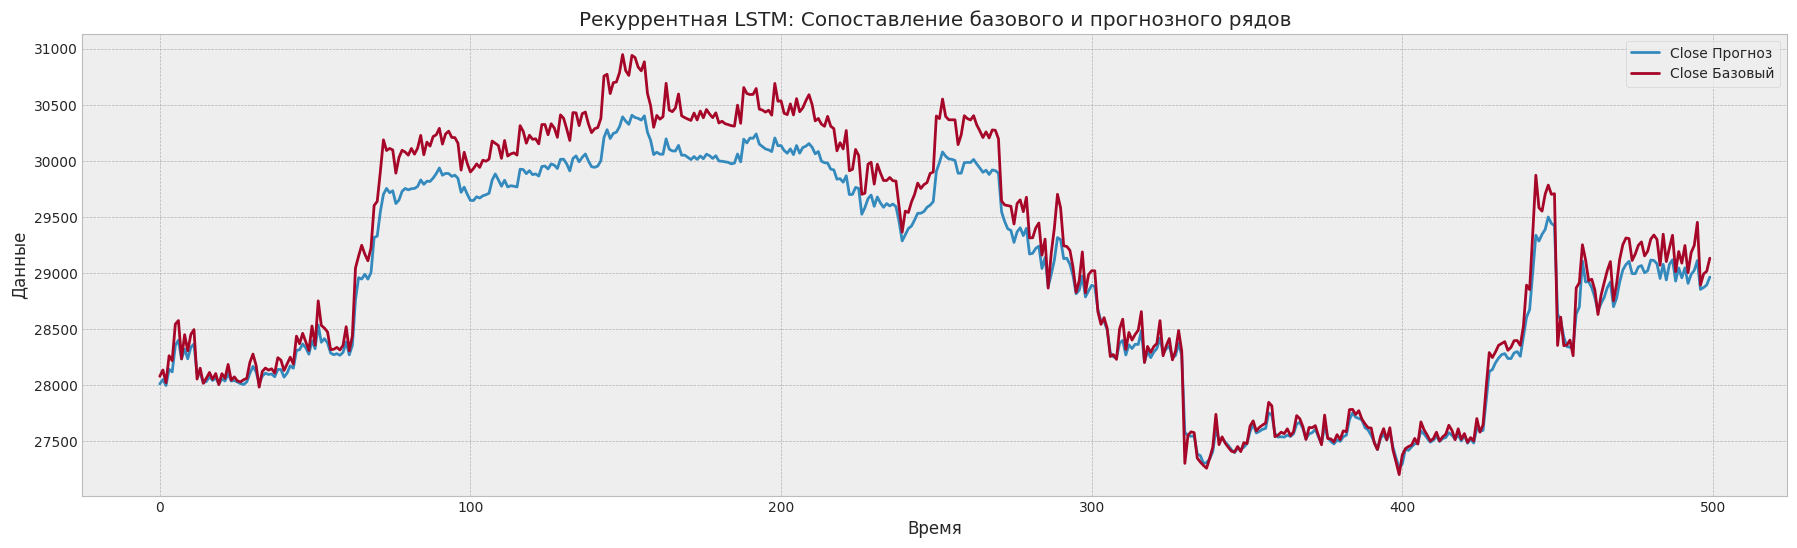

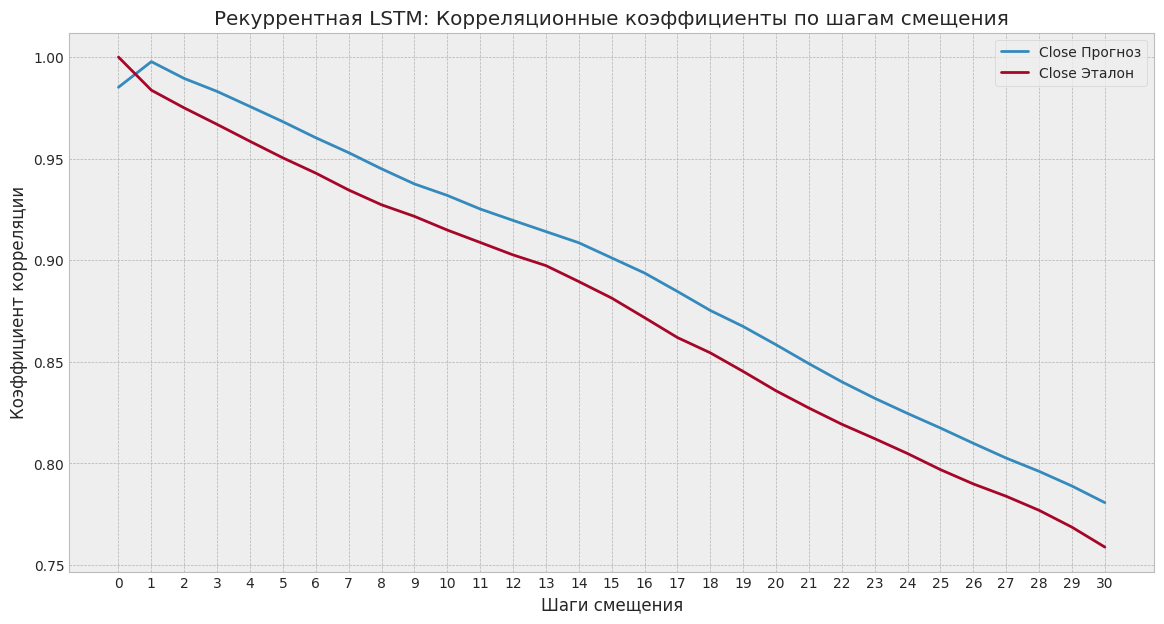

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(40, return_sequences=True, input_shape= (x_test.shape[1:])))
model_lstm.add(LSTM(20, return_sequences=False))
model_lstm.add(Dense(25,activation='relu'))
model_lstm.add(Dense(y_test.shape[1],activation='linear'))


# Обучение модели 20 эпох
train_eval_net(model_lstm, train_datagen, val_datagen, [(20, Adam(lr=1e-4)),
                                                          (20, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Рекуррентная LSTM')

In [ ]:
# Пересохранение обученной модели полностью (веса и архитектура) после всех эпох
model_lstm.save('/content/drive/MyDrive/model_lstm_BTC_all.h5')
model_conv_2.save('/content/drive/MyDrive/model_convBCT_2_all.h5')

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
COMIS = 0.002
MAKE_LOG = True

In [ ]:
# функция определяет "что делать" и на сколько из остатков денег/акций
def buyorsale(predict):
    '''
    Функция определяет класс действия на основе
    вектора предсказаний predict
    input:
    predict - вектора предсказаний
    return:
    класс действия -
                    0 - ничего не делать
                    1 - покупать
                    2 - продавать

    уверенность в действии
    '''
    dif_buy = 0
    dif_sell = 0
    len_period = len(predict)
    i_buy = len_period
    i_sell = len_period
    for i in range(len_period-1):
        for j in range(len_period-1):
            dif = predict[j]-predict[i]

            if j > i and dif > dif_buy:
                dif_buy = dif
                i_buy = i  # момент продажи

            if j > i and dif < dif_sell:
                dif_sell = dif
                i_sell = i  # момент покупки
    dif_buy = abs(dif_buy)
    dif_sell = abs(dif_sell)
    #print(i_sell, dif_sell)
    #print( i_buy, dif_buy)
    # выводим "что делать?" и с каким коэф-том
    # коэф-т покупки зависит от соот-я выгод от продажи и покупки
    # на отрезке будущем
    if dif_buy == 0 and dif_sell == 0:
        return 0, 0  # спим

    elif  i_buy == 0 and i_buy != i_sell:
          # даем вес dif_sell будущему взависимости от удаленности
          dif_sell_prob = dif_sell*(len_period-i_sell)/len_period
          # сравниваем взвешанную выгоду от действий типа short в дальнем будащем
          # с выгодой от действий для типа long на ближайшем шаге
          if dif_buy > dif_sell_prob:
            # определяем уверенность в покупке от сравнения dif_sell_prob и dif_buy
            force = 1 - dif_sell_prob/dif_buy
            return 1, force  # покупаем
          else:
            return 0, 0  # спим

    elif  i_sell == 0 and i_sell != i_buy:
        # даем вес dif_buy будущему взависимости от удаленности
        dif_buy_prob = dif_buy*(len_period-i_buy)/len_period
        # сравниваем взвешанную выгоду от действий типа long в дальнем будащем
        # с выгодой от действий для типа short на ближайшем шаге
        if dif_sell > dif_buy_prob:
            # определяем уверенность в продаже от сравнения dif_buy_prob и dif_sell
            force = 1 - dif_buy_prob/dif_sell
            return 2, force  # продаем
        else:
          return 0, 0   # спим
    else:
        return 0, 0 # спим



def prepare_data(df_in: pd.DataFrame,
                 #use_columns:list,
                 depth:int,
                 scaler: object):
    # обогащаем данные ранее созданной функцией
    ds = make_data(df_in, DIFFBACK, SET_WIND, FEATURES, ROLLS)
    # обогащаем данные ранее созданной функцией
    ds = add_from_datetime(ds)
    # переводим Volume в Log_Volume в df_data
    ds['Log_Volume'] = np.log(df_in['Volume'])
    # Удаление строк с неполными данными
    ds.dropna(inplace=True)
    # оставляем на глубину depth и только нужные колонки
    x_data = ds[TRAIN_COLUMNS][-depth:].values
    # нормализуем
    x_data = scaler.transform(x_data)
    # выводим с добавлением измерения по axis=0
    return np.expand_dims(x_data, axis=0)



def making_signals(past_df: pd.DataFrame,
                    check_df: pd.DataFrame,
                    pred_lag: int,
                    model: object,
                    control_enter = False,
                    stop_loss = 1.,
                    use_force_action = False,
                    show_unique_signals = True
                    ):
    """
    Args:
        past_df (pd.DataFrame) - прошлые OHCL данные до тестируемых
        check_df (pd.DataFrame) - тестируемые OHCL данные
        pred_lag: int - шаг предсказания
        model (class) - ранее обученная модель
        control_enter (bool) - контролировать ли вход в сделку
        stop_loss (float) - уровень падения цены (от 0 до 1) при которм нужно продать
        use_force_action (bool): False - выводим чистые действия,
                                 True - выводим действия с учетом уверенности,
        show_unique_signals (bool) - показать ли состав чистых действий

    Return:
         df_signal(pd.DataFrame) - копия OHCL датафрейма из check_df с колонкой Signal
    """
    # сбор действий
    all_actions = []
    # сбор уверенности действия
    force_actions = []
    # сбор последнего активного действия и цены
    last_position = [0, 0]
    # итеррируемся по длине изучаемого датафрейма
    # print('metka_1')
    # берем на страте прошлые данные
    for i in tqdm(range(check_df.shape[0]-pred_lag), unit ="step",
                      desc ="Пробегаемся по всем отсчетам"):
        if not i: # берем на страте прошлые данные
            #print('metka_2')
            check_data = past_df.copy()
        # далее отшипываем вначале 1 свечу
        else: #  и присоединяем в коней новую из изучаемого датафрейма
            #print('metka_3')
            check_data = check_data[1:].append(check_df[i:i+1])
        #print('metka_4', check_data.shape)
        # обогащаем данные по аналогии как готовили для убучени
        to_pred = prepare_data(check_data,
                                #use_columns:list,
                                SEQ_LEN,     # ранее заданная глубина сбора данных в прошлое
                                y_scaler  # ранее инициализированный и обученный скэйлер
                               )

        # предсказание модели
        pred = model.predict(to_pred, verbose=False)
        pred = y_scaler.inverse_transform(pred)
        if MAKE_LOG: pred = np.exp(pred)
        #print(pred)
        cls_action, force =  buyorsale(pred[0])
        #print(cls_action, force)
        #print()


        # переводим текущий ответ сети (0,1,2) в (0,1,-1)
        sign = -1 if cls_action == 2  else 1

        price = check_data.Close[-1]        # текущая цена
        diff = (last_position[1] - price)   # разница цены прошлого активного действия и текущей цены
        proof = (-1)*sign*diff              # разница на знак действия

        # если контролируем вход в сделку
        if control_enter:
            # если вводим не чистое действия (-1,0,1), а его силу*(-1,0,1)
            if use_force_action:
              # если активное действие
              condition_1 = cls_action
            # если вводим чистые действия (-1,0,1)
            else:
              # активное действие и отличается от прошлого активного действия
              condition_1 = (last_position[0] != cls_action or not cls_action)
            # если proof>0, то есть хотим купить при падении или продать при росте к прошлому активному действию
            condition_2 = (proof>0)
            # если предполагаемый доход от сделки выше стоимости сделки
            condition_3 = ((proof- COMIS*price) > 0)

            if condition_1 and condition_2 and condition_3:
                all_actions.append(cls_action)  # собираем класс действия
                force_actions.append(force)     # собираем уверенность действия
                last_position[0] = cls_action   # запоминаем отдельно класс действия
                last_position[1] = price        # запоминаем цену действия
            # если класс действия 0 или совпадает с активным прошлым действием
            else:
                #print(f'Контроль входа в сделку не пройден')
                cls_action = 0
                all_actions.append(cls_action)  # собираем как 0 класс действия
                force_actions.append(1)         # собираем как 100% уверенность действия

        # если не контролируем вход в сделку
        else: # собираем без коррекций
            all_actions.append(cls_action)  # собираем класс действия
            force_actions.append(force)     # собираем уверенность действия
        # если stop_loss не равен 0, то есть контролируем потери
        if (1-stop_loss):
            # если предполагаемое действие не продажа
            # и бумаги в руках упали ниже заданного stop_loss
            if cls_action != 2 and price < last_position[1]*stop_loss:
                print(f'STOP_LOSS на шаге {i}')
                print()
                # корректируем наши последние собранные действия
                all_actions[-1] = 2        # продаем
                force_actions[-1] = 1      # однозначно
                last_position[0] = 2       # фиксируем действие
                last_position[1] = price   # запоминаем цену действия

    # переводим классы сигналов в массив сигналов
    all_actions = np.array(all_actions)
    signals = np.zeros(all_actions.shape[0]) # массив нулей
    signals[all_actions == 1] =  1           # при покупке сигнал 1
    signals[all_actions == 2] = -1           # при продаже сигнал -1
    if show_unique_signals:
      print(f' Итоговые типы действий {np.unique(signals, return_counts=True)} и их количество')
    # смещаем на pred_lag
    df_signal = check_df[pred_lag:].copy()
    # берем действия действия с учетом их уверенности
    if  use_force_action:
        df_signal['Signal'] = np.array(signals*force_actions)
    # берем чистые действия действия
    else:
        df_signal['Signal'] = np.array(signals)
    # берем чистые действия действия
    return  df_signal

In [ ]:
x_data_train, x_data_test

In [ ]:
df_test_signal = making_signals(x_data_train,
                                x_data_test,
                                model = model,
                                pred_lag = 1,
                                control_enter = True,
                                stop_loss = 0.9,
                                use_force_action = False,
                                show_unique_signals = True
                                )

In [ ]:
model1.fit(
    x=X,
    y=y,
    validation_split=0.3,
    batch_size=16,
    epochs=30,
)

In [ ]:
# Применение модели для прогнозирования значений на новых данных
y_pred1 = model1.predict(X)
print(y_pred1.shape)

### Вторая проба

In [ ]:
X = data[['Open', 'High', 'Low', 'Volume','Close']].astype("float32")
y = data['Close'].astype("float32")
print(y.shape)

In [ ]:
# Масштабирование признаков
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# y_scaled = scaler.fit_transform(y)

In [ ]:
X_scaled.shape

In [ ]:
# Создание объекта TimeSeriesForecaster

# В модели TimeseriesForecaster библиотеки AutoKeras вы можете указать прогнозное окно (predict horizon),
# которое определяет, на сколько шагов в будущее вы хотите сделать прогноз. Этот параметр задается аргументами
# predict_from и predict_until при создании объекта модели.Например, если вы хотите сделать прогноз на 10 шагов
# вперед, начиная с момента времени t=1, то вам нужно создать объект модели следующим образом:

# predict_from = 1
# predict_until = 10
# lookback = 3

# После обучения модели, она будет принимать на вход последовательность исторических данных длиной
# lookback и будет делать прогноз на predict_until - predict_from шагов вперед от момента времени predict_from.

predict_from = 1
predict_until = 2
lookback = 8 # lookback должен быть кратен batch_size
clf = ak.TimeseriesForecaster(
    lookback=lookback,  # количество предыдущих временных шагов, которые будут использоваться для прогнозирования следующего временного шага
    predict_from= predict_from,  # это индексы временных шагов, на которых модель будет производить прогнозы
    predict_until= predict_until, # модель будет прогнозировать значения для временных шагов с индексами от predict_from до predict_until.
    max_trials=20,  # количество различных моделей, которые будут протестированы
    objective="val_loss",  # целевая метрика, на основе которой будет производиться оптимизация модели
    overwrite=True,  # если True, то при повторном запуске обучения модели, будут перезаписаны результаты прошлого запуска
    # directory='/path/to/directory',
    seed=42,  # начальное значение генератора случайных чисел для повторяемости эксперимента
    metrics=['mse']  # список дополнительных метрик, которые будут отслеживаться в процессе обучения
)

# Обучение модели
clf.fit(
    x=X_scaled,
    y=y,
    validation_split=0.3,
    batch_size=4,
    epochs=5
)

In [ ]:
model = clf.export_model()
# Получите архитектуру модели в виде JSON строки
model_json = model.to_json()

print("Model architecture:")
print(model_json)

In [ ]:
model.summary()

In [ ]:
X_scaled.shape

In [ ]:
X_train = X_scaled.reshape(-1, lookback, 5)

In [ ]:
# X_train = X_scaled.reshape(X_scaled.shape[0], -1, lookback)
X_train.shape

In [ ]:
# X_train = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

In [ ]:
model1.fit(
    X,
    y,
    validation_split=0.3,
    batch_size=4,
    epochs=5)